# 1
Open lab notebook and copy all code until the FashionMNIST section.

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

Since `X` consists of values from `-3` to `3`, we use `torch.rand` to generate those values.

`torch.rand` produces values in `[0, 1]`. Multiplying by `6`, we end up with values in `[0, 6]`, and subtracting `3` we end up with values in `[-3, 3]`:

We also `0.1` as the second argument to `torch.normal` because we need standard deviation equal to `0.1`:

In [23]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.rand((num_examples, len(w)))*6-3
    y = X @ w + b
    y += torch.normal(0, 0.1, y.shape)
    return X, y.reshape(-1, 1)

Since the model is $1\cdot X-1+\epsilon$, we set `true_w` to `1` and `true_b` to `-1`.
`true_w` contains all coefficients of `X`, and `true_b` is the bias.

Because $X\in\mathbb R^{60\times 1}$ we also pass `60` instead of `1000` to `synthetic_data`:

In [24]:
true_w = torch.tensor([1.])
true_b = -1
features, labels = synthetic_data(true_w, true_b, 60)

In [25]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [26]:
def load_array(data_arrays, batch_size, is_train=True): 
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

`batch_size` is already set to `10`:

In [27]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

Our data, `X`, consists of `60` examples each of `1` feature (one input to our network). We then use `nn.Linear(1, 1)` instead of `nn.Linear(2, 1)`:

In [28]:
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(1, 1))

Setting the weights and bias to `1`:

In [29]:
net[0].weight.data.fill_(1)
net[0].bias.data.fill_(1)

tensor([1.])

We need to implement mean squared error loss manually:
- compute difference between correct outputs and predicted outputs
- compute square of the difference
- compute the mean

In [30]:
def mse_loss(model_outputs, correct_outputs):
    return ((model_outputs - correct_outputs) ** 2) \
    .mean()

In [31]:
loss = mse_loss

We need to manually implement SGD. We need:
- a function to set the gradients to `0`, like `optimizer.zero_grad()` does
- a function to update the parameters, like `optimizer.step()` does

We need the `None` check because initially `.grad` is not set. `.grad` only gets set after the first call to `.backward()`, but it is convenient in code to call `zero_grad()` before calling `backward()`:

In [32]:
def sgd_zero_grad(parameters):
    for parameter in parameters:
        if parameter.grad is not None:
            parameter.grad.fill_(0)

In [33]:
def sgd_step(parameters, lr):
    with torch.no_grad():
        for parameter in parameters:
            parameter.sub_(lr*parameter.grad)

We need to set the number of epochs to `25` and make sure to pass `0.05` as the learning rate to `sgd_step`:

In [34]:
num_epochs = 25
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        sgd_zero_grad(net.parameters())
        l.backward()
        sgd_step(net.parameters(), 0.05)
    l = loss(net(features), labels)
    print(f'Epoch {epoch + 1}, Loss {l:f}')

Epoch 1, Loss 1.119192
Epoch 2, Loss 0.338116
Epoch 3, Loss 0.103980
Epoch 4, Loss 0.036174
Epoch 5, Loss 0.016087
Epoch 6, Loss 0.010432
Epoch 7, Loss 0.008668
Epoch 8, Loss 0.008082
Epoch 9, Loss 0.007920
Epoch 10, Loss 0.007892
Epoch 11, Loss 0.007886
Epoch 12, Loss 0.007923
Epoch 13, Loss 0.007899
Epoch 14, Loss 0.007866
Epoch 15, Loss 0.007926
Epoch 16, Loss 0.007874
Epoch 17, Loss 0.007866
Epoch 18, Loss 0.007864
Epoch 19, Loss 0.007882
Epoch 20, Loss 0.007884
Epoch 21, Loss 0.007872
Epoch 22, Loss 0.007870
Epoch 23, Loss 0.007868
Epoch 24, Loss 0.007869
Epoch 25, Loss 0.007870


The errors are fairly small, so our code seems to be working well:

In [35]:
w = net[0].weight.data
print('Error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('Error in estimating b:', true_b - b)

Error in estimating w: tensor([-0.0022])
Error in estimating b: tensor([-0.0115])


These are the learned parameters, and they are close to the correct parameters (which are `1` and `-1` since the model based on which we generated the data is $y-1\cdot X-1+\epsilon$):

In [37]:
w, b

(tensor([[1.0022]]), tensor([-0.9885]))

# 2
Open lab notebook and copy all code from the FashionMNIST and softmax regression sections:

In [49]:
import torchvision
from torchvision import transforms

# `ToTensor()` converts the image data from PIL type to 32-bit floating point
# tensors. It also divides all numbers by 255, so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [50]:
def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [51]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Make sure we use 30000 validation images and 30000 training images:

In [52]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [30000, 30000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

Set batch size to `100`:

In [53]:
batch_size = 100
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

Set the weights to `1` using `nn.init.ones_`.

Note: `net.apply` applies a function to every layer in a network. Below, if the layer is a linear layer, its weights are set to `1` (it wouldn't make sense to do this to a `ReLU`, because the relu has no weights to initialize):

In [54]:
# PyTorch does not implicitly reshape the inputs. Thus, we define the flatten
# layer to reshape the inputs before the linear layer in our network.
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.ones_(m.weight)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

Loss function is already the cross entropy loss :)

In [55]:
loss = nn.CrossEntropyLoss()

Set learning rate to `0.15`. Optimizer is already the mini-batch SGD: it is the SGD because we use SGD in the code below, and it is `mini-batch` because we pass multiple pictures through the network at once:

In [56]:
lr = 0.15
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [57]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [58]:
def train_epoch(net, train_iter, loss, optimizer):  
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [59]:
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

Set number of epochs to `15`:

In [60]:
num_epochs = 15
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 0.76, Train accuracy 74.78, Validation loss 0.59, Validation accuracy 80.20
Epoch 2, Train loss 0.55, Train accuracy 81.08, Validation loss 0.52, Validation accuracy 81.86
Epoch 3, Train loss 0.51, Train accuracy 82.52, Validation loss 0.51, Validation accuracy 82.56
Epoch 4, Train loss 0.49, Train accuracy 83.16, Validation loss 0.48, Validation accuracy 83.55
Epoch 5, Train loss 0.48, Train accuracy 83.58, Validation loss 0.57, Validation accuracy 79.50
Epoch 6, Train loss 0.46, Train accuracy 84.30, Validation loss 0.47, Validation accuracy 84.01
Epoch 7, Train loss 0.46, Train accuracy 84.25, Validation loss 0.45, Validation accuracy 84.70
Epoch 8, Train loss 0.45, Train accuracy 84.70, Validation loss 0.46, Validation accuracy 84.43
Epoch 9, Train loss 0.44, Train accuracy 84.82, Validation loss 0.45, Validation accuracy 84.86
Epoch 10, Train loss 0.44, Train accuracy 84.76, Validation loss 0.46, Validation accuracy 84.01
Epoch 11, Train loss 0.43, Train accura

Exercise doesn't ask to plot loss, but it doesn't hurt to :)

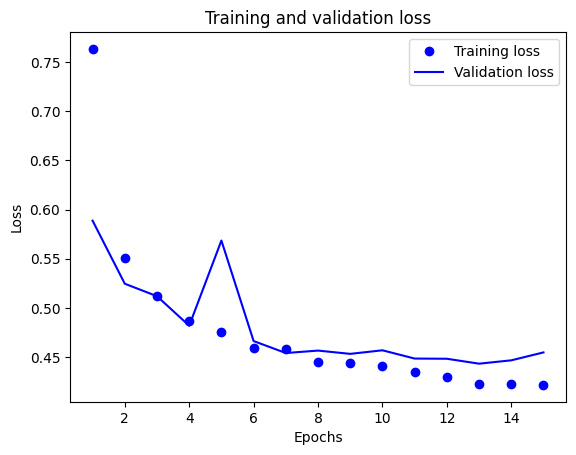

In [61]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1) 
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss') 
    plt.title('Training and validation loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()  
    plt.show()

plot_loss(train_loss_all, val_loss_all)

Plotting the accuracy:

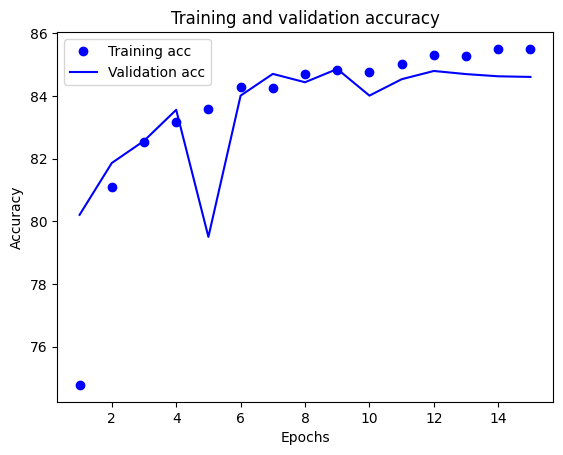

In [63]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, val_acc_all)

Evaluating on the test set:

In [64]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.48, Test accuracy 83.61


To classify `20` images, pass `20` to the `predict` function:

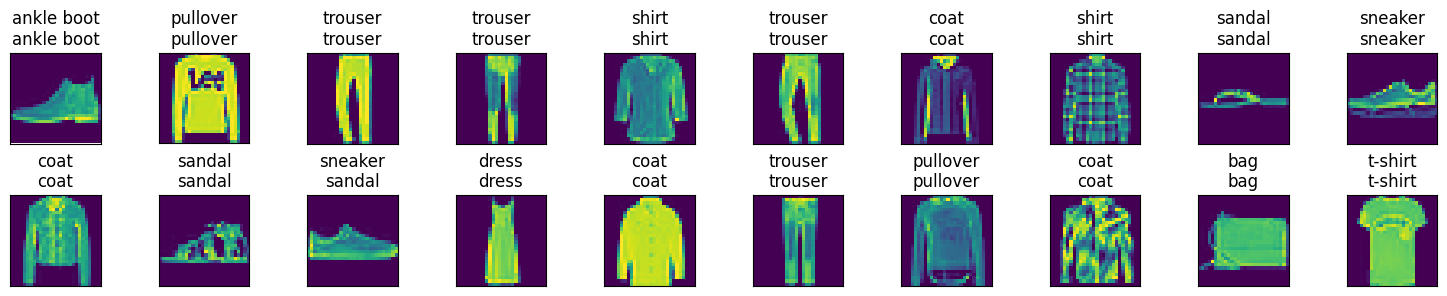

In [65]:
def predict(net, test_iter, n=18):
    """Predict labels."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 2, int(n/2), titles=titles[0:n])

predict(net, test_iter, 20)